## Computer Vision on Public Lands Webcams

#### Date: 9/25/25
#### Author: Eric Englin

Goal: The goal of this notebook is to create a YOLOv11 method to track parking lot utilization over time. It is meant to be run locally while finetuning a method that can eventually be scaled for longer-term monitoring and data collection. 

In [1]:
#import libraries
import os
import time
from datetime import datetime, timezone
import pandas as pd
import numpy as np

import cv2
import yt_dlp
from ultralytics import YOLO
from collections import defaultdict
import supervision as sv
from bs4 import BeautifulSoup
import requests
from IPython.display import display, Image
from PIL import Image as Img
from PIL import ImageTk
from urllib.parse import urljoin


#### Download stream snapshot from webcam URL

In [2]:
# note: this link changes (daily?). Go to https://www.ipcamlive.com/willowcreektrail, inspect element, and search 
# for the word "snapshot" to get the latest link. We could code a step here that pulls the component content systematically
# additional note: my more resilient link didn't work, gotta get dynamic code once more
snapshot_url = "https://s94.ipcamlive.com/streams/5eomcjz02e6fvtfqs/snapshot.jpg"

# defining user agent as I attempt to increase the image quality retrieved with the requests.get call. don't think it's changing anything really
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36"}

In [3]:
def get_stream_jpg(snapshot_url):
    response = requests.get(snapshot_url, headers=headers)
    
    #Nineveh question: what is/why is this -3 thing here?
    ts = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S_%f")[:-3]
    
    img_name = 'image/snapshot' + ts + ".jpg"
    
    with open(img_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    return img_name

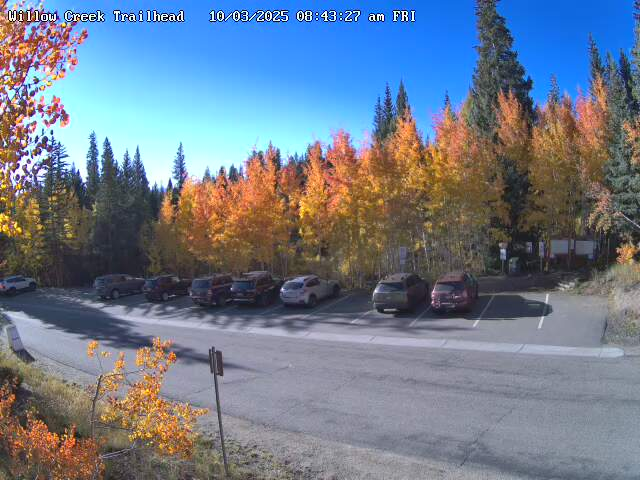

In [4]:
img_name = get_stream_jpg(snapshot_url)
# display inline
display(Image(filename=img_name))

## YOLO testing

#### YOLO testing to predict cars, trucks, and buses


image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20251003_144422_138.jpg: 480x640 9 cars, 1 truck, 851.8ms
Speed: 3.6ms preprocess, 851.8ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)
Detected cars: 9
Car 1: bbox=(279.3, 274.6, 342.2, 308.2), conf=0.82
Car 2: bbox=(94.3, 273.3, 145.8, 299.9), conf=0.76
Car 3: bbox=(430.8, 271.1, 479.8, 314.0), conf=0.74
Car 4: bbox=(190.2, 274.0, 233.0, 307.3), conf=0.72
Car 5: bbox=(0.1, 274.7, 37.4, 294.8), conf=0.67
Car 6: bbox=(143.0, 274.9, 190.7, 302.4), conf=0.67
Car 7: bbox=(371.0, 272.2, 430.8, 313.9), conf=0.63
Car 8: bbox=(228.2, 270.7, 279.5, 306.9), conf=0.38
Car 9: bbox=(0.0, 280.3, 16.6, 296.5), conf=0.29


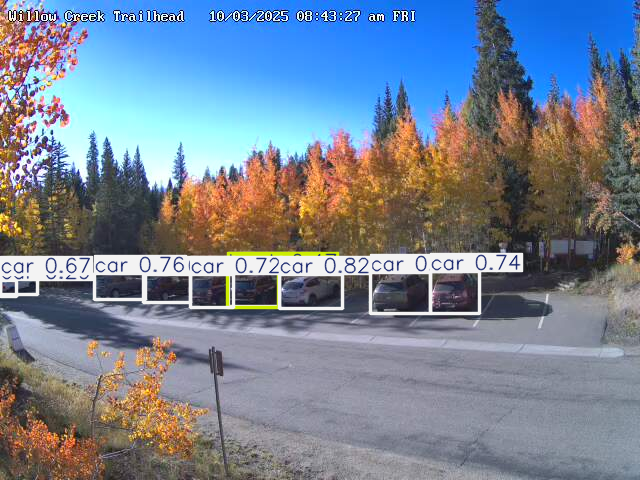

In [5]:
# Load the YOLO model
model = YOLO('yolo11l.pt')

results = model.predict(source = img_name, classes = [2,3,5,7]) 
# results[0] contains detections for the first image
res = results[0]

# res.boxes.cls are class indices (tensor). Convert to numpy.
if hasattr(res, "boxes") and len(res.boxes) > 0:
    class_ids = res.boxes.cls.cpu().numpy().astype(int)  # e.g., [2, 0, 2, ...]
    confidences = res.boxes.conf.cpu().numpy()
else:
    class_ids = np.array([], dtype=int)
    confidences = np.array([])

# COCO class id for "car" is 2
CAR_CLASS_ID = 2
car_mask = (class_ids == CAR_CLASS_ID)
num_cars = int(car_mask.sum())

print(f"Detected cars: {num_cars}")

# Optionally, print each car bbox and confidence
if num_cars > 0:
    boxes = res.boxes.xyxy.cpu().numpy()  # x1,y1,x2,y2
    car_boxes = boxes[car_mask]
    car_confs = confidences[car_mask]
    for i, (box, conf) in enumerate(zip(car_boxes, car_confs), start=1):
        x1, y1, x2, y2 = box
        print(f"Car {i}: bbox=({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}), conf={conf:.2f}")

# Optional: show annotated image inline (Jupyter)
# This will save an annotated image to 'runs/detect/predict' by default. You can also render manually:
annotated = res.plot()  # returns an np.ndarray image with boxes drawn
display(Img.fromarray(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)))

#### YOLO testing to track cars, trucks, and buses


image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20251003_144422_138.jpg: 480x640 9 cars, 1 truck, 724.2ms
Speed: 3.1ms preprocess, 724.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)
Detected cars: 9
Car 1: bbox=(279.3, 274.6, 342.2, 308.2)
Car 2: bbox=(94.3, 273.3, 145.8, 299.9)
Car 3: bbox=(430.8, 271.1, 479.8, 314.0)
Car 4: bbox=(190.2, 274.0, 233.0, 307.3)
Car 5: bbox=(0.1, 274.7, 37.4, 294.8)
Car 6: bbox=(143.0, 274.9, 190.7, 302.4)
Car 7: bbox=(371.0, 272.2, 430.8, 313.9)
Car 8: bbox=(228.2, 270.7, 279.5, 306.9)
Car 9: bbox=(0.0, 280.3, 16.6, 296.5)


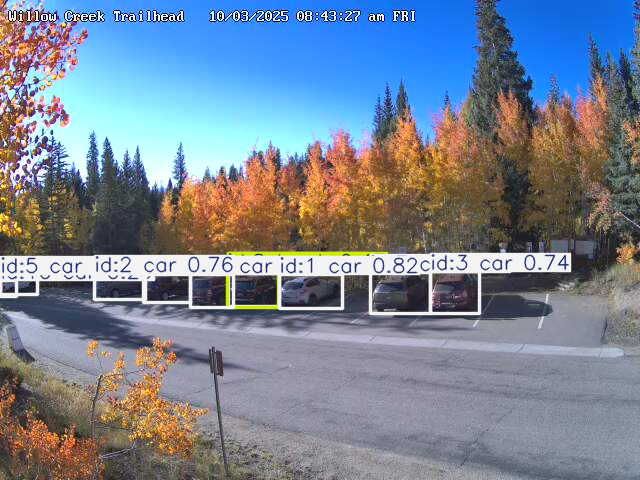

In [6]:
# Load the YOLO model
model = YOLO('yolo11l.pt')

results = model.track(source = img_name, classes = [2,3,5,7], persist=True) 

# results[0] contains detections for the first image
res = results[0]

# res.boxes.cls are class indices (tensor). Convert to numpy.
if hasattr(res, "boxes") and len(res.boxes) > 0:
    class_ids = res.boxes.cls.cpu().numpy().astype(int)  # e.g., [2, 0, 2, ...]
    confidences = res.boxes.conf.cpu().numpy()
else:
    class_ids = np.array([], dtype=int)
    confidences = np.array([])

# COCO class id for "car" is 2
CAR_CLASS_ID = 2
car_mask = (class_ids == CAR_CLASS_ID)
num_cars = int(car_mask.sum())

print(f"Detected cars: {num_cars}")

# Optionally, print each car bbox and confidence
boxes = res.boxes.xyxy.cpu().numpy()  # x1,y1,x2,y2
car_boxes = boxes[car_mask]
for i, box in enumerate(car_boxes, start=1):
    x1, y1, x2, y2 = box
    print(f"Car {i}: bbox=({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

# Optional: show annotated image inline (Jupyter)
# This will save an annotated image to 'runs/detect/predict' by default. You can also render manually:
annotated = res.plot()  # returns an np.ndarray image with boxes drawn
display(Img.fromarray(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)))

## YOLO function testing

If all the above chunks work, you should now be set up to run the code continuously with vehicle tracking.
- YOLO testing to track cars, trucks, and buses
- Make better looking boxes around vehicles
- Continuously run the model
- Create a dataset of the parking lot capacity over time

In [7]:
# Load the YOLO model
model = YOLO('yolo11l.pt')

class_list = model.names 

def capture_frames(snapshot_url):
    
    resultsList = []
    countFrames = 0

    while True: 

        img_name = get_stream_jpg(snapshot_url)
    
        # Run YOLO tracking on the frame
        results = model.track(source = img_name, classes = [2,3,5,7], persist = True) 
       
        # results[0] contains detections for the first image
        res = results[0]
        frame = res.orig_img
        
        # prep timestamp for file name
        current_datetime = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
        
        # Ensure results are not empty
        if results[0].boxes.data is not None:
            # Get the detected boxes, their class indices, and track IDs
            boxes = results[0].boxes.xyxy.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            class_indices = results[0].boxes.cls.int().cpu().tolist()
            confidences = results[0].boxes.conf.cpu()
            
            # I want to practice printing all of the parking spot midpoint areas... I feel this SHOULD be done manually
            # though it certainly could be automated to start and then manually improved
            cv2.rectangle(frame, (549, 340), (600, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (490, 340), (547, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (430, 340), (488, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (380, 340), (428, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (330, 340), (378, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (280, 340), (328, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (240, 340), (278, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (195, 340), (238, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (165, 340), (193, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (140, 340), (163, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (112, 340), (138, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (102, 340), (110, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (75, 340), (100, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (40, 340), (73, 265), (0, 255, 0), 1)
            cv2.rectangle(frame, (5, 340), (38, 265), (0, 255, 0), 1)
            # # draw the road/area below
            # # Define polygon vertices
            # pts = np.array([[5, 295], [635, 340], [635, 475], [420, 475], [5, 345]], np.int32)
            # # Reshape for polylines: (number_of_vertices, 1, 2)
            # pts = pts.reshape((-1, 1, 2))
            # cv2.polylines(frame, [pts], True, (255, 192, 203), 1) # Pink outline


            # Loop through each detected object
            for box, track_id, class_idx, conf in zip(boxes, track_ids, class_indices, confidences):
                x1, y1, x2, y2 = map(int, box)
                cx = (x1 + x2) // 2  # Calculate the center point
                cy = (y1 + y2) // 2            
        
                class_name = class_list[class_idx]
        
                cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                
                # cv2.putText(frame, f"ID: {track_id} {class_name}", (x1, y1 - 10),
                #             cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 255), 1)
                # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1) 

                dfKeyFeatures = pd.DataFrame({'id' : [track_id], 
                                              'class' : [class_name], 
                                              'confidence' : [conf], 
                                              'cx' : [cx], 
                                              'cy' : [cy], 
                                              'timestamp' : [current_datetime]})
                resultsList.append(dfKeyFeatures)
        
        
        ### Save frame    
        # Save as PNG
        filename ='annotated_image'
        cv2.imwrite(f"{filename}/frame_{str(current_datetime)}.png", frame)
        # YOUR FILE PATH HERE
        print(f"Saved frame {countFrames}, {current_datetime}", "; detected ", len(res.boxes.cls.cpu().numpy().astype(int)), " cars and trucks")
        
        # set a count and iterate so while loop doesn't actually go forever
        countFrames += 1
        if countFrames % 20 == 0 :
            combined_df = pd.concat(resultsList)
            ts_for_export = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
            # YOUR FILE PATH HERE
            datafolder =r'C:\Users\Nineveh.OConnell\OneDrive - DOT OST\volpe-portfolio-PublicLands - AI Real-Time Parking Project\Data'
            combined_df.to_csv(f"{datafolder}/data_download_export_{str(ts_for_export)}.csv", index=False) 
        if countFrames > 2:
            break

        # sleep for 50 seconds -- it really only updates like once a minute, we don't need excessive data saved
        time.sleep(50)

    combined_df = pd.concat(resultsList)
    ts_for_export = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    # YOUR FILE PATH HERE
    datafolder =r'C:\Users\Nineveh.OConnell\OneDrive - DOT OST\volpe-portfolio-PublicLands - AI Real-Time Parking Project\Data'
    combined_df.to_csv(f"{datafolder}/data_download_export_{str(ts_for_export)}.csv", index=False) 

In [8]:
if __name__ == "__main__":
    print("Stream URL:", snapshot_url)
    capture_frames(snapshot_url)


Stream URL: https://s94.ipcamlive.com/streams/5eomcjz02e6fvtfqs/snapshot.jpg

image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20251003_144425_713.jpg: 480x640 9 cars, 1 truck, 708.5ms
Speed: 3.9ms preprocess, 708.5ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)
Saved frame 0, 2025-10-03 10-44-26 ; detected  10  cars and trucks

image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20251003_144517_112.jpg: 480x640 9 cars, 535.2ms
Speed: 1.6ms preprocess, 535.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)
Saved frame 1, 2025-10-03 10-45-17 ; detected  9  cars and trucks

image 1/1 c:\Users\Nineveh.OConnell\OneDrive - DOT OST\Documents\code\Public-Lands-Computer-Vision\Willow Creek Trail\image\snapshot20251003_144608_033.jpg: 480x640 9 cars, 698.6ms
Speed: 1.4ms preprocess, 698.6ms infere